In [1]:
import cortex

In [2]:
import nibabel as nb
from nilearn import surface
import glob
import numpy as np

import pandas as pd

/Users/gdehol/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
df = []

In [4]:
for subject, session in [('bm', 'odc'),
                         ('de', 'odc1'),
                         ('eo', 'odc'),
                         ('ms', 'odc2'),
                         ('ns', 'odc'),
                         ('tr', 'odc')]:
    
    left, right = cortex.db.get_surf(f'odc.{subject}', 'fiducial')
    
    for hemi in ['lh', 'rh']:
        mask_str = 'V1{}'.format(hemi[:1])

        surfaces1 = glob.glob(f'/data/odc/derivatives/sampled_giis_cv/sub-{subject}/ses-{session}/cv/sub-{subject}_ses-{session}_cv-1_left_over_right_desc-zmap-depth-*_cv-1_hemi-{hemi}.gii')
        surfaces2 = glob.glob(f'/data/odc/derivatives/sampled_giis_cv/sub-{subject}/ses-{session}/cv/sub-{subject}_ses-{session}_cv-2_left_over_right_desc-zmap-depth-*_cv-2_hemi-{hemi}.gii')

        zmap1 = np.mean([surface.load_surf_data(s) for s in surfaces1], 0)
        zmap2 = np.mean([surface.load_surf_data(s) for s in surfaces2], 0)

        mask = cortex.utils.get_roi_verts(f'odc.{subject}', mask_str)[mask_str]
        
        if hemi == 'rh':
            mask -= len(left[0])

        zmap1 = zmap1[mask]
        zmap2 = zmap2[mask]

        nonzero_mask = ~((zmap1 == 0) | (zmap2 == 0))

        zmap1 = zmap1[nonzero_mask]
        zmap2 = zmap2[nonzero_mask]


        d = pd.DataFrame({'zmap1':zmap1, 'zmap2':zmap2, 'subject':subject, 'hemi':hemi, 'session':session})

        df.append(d)

In [5]:
df = pd.concat(df)

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
sns.set_context('poster')

In [8]:
subjects = df.subject.unique().tolist()

In [9]:
df['subject_'] = df['subject'].map(lambda s: subjects.index(s) + 1)

df['First half session'] = df['zmap1']
df['Second half session'] = df['zmap2']

In [10]:
df['Hemisphere'] = df['hemi'].map({'lh':'Left', 'rh':'Right'})

/Users/gdehol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


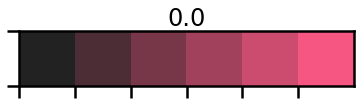

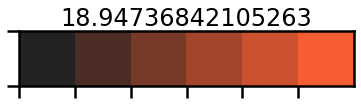

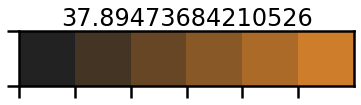

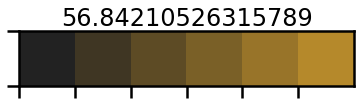

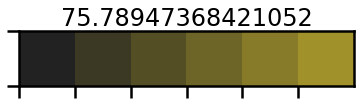

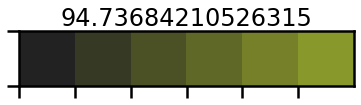

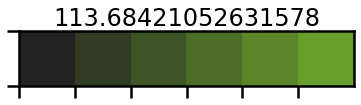

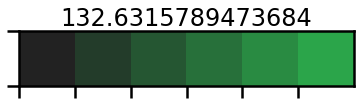

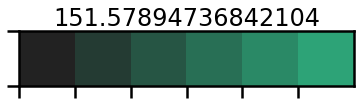

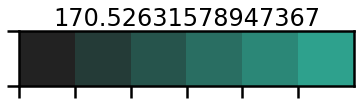

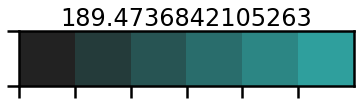

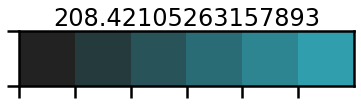

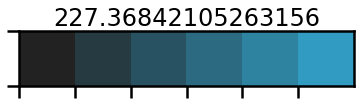

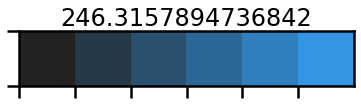

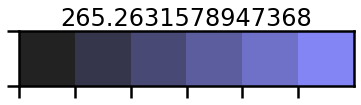

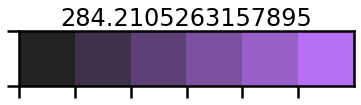

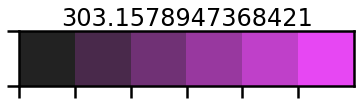

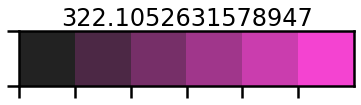

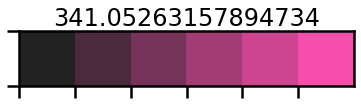

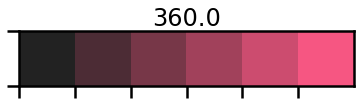

In [168]:
for i in np.linspace(0, 360, 20.):
    sns.palplot(sns.dark_palette((i, 90, 60), input="husl"))
    plt.title(i)

In [226]:
subject = 3

In [231]:
import matplotlib.colors as colors


In [236]:
norm = colors.LogNorm(vmin=0, vmax=100)

(0.13470839274065943, 0.13669530477557565, 0.13504770405220984, 1.0)

84.112

In [405]:
sns.set(font='helvetica', style='white', font_scale=2.5)

/Users/gdehol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/gdehol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


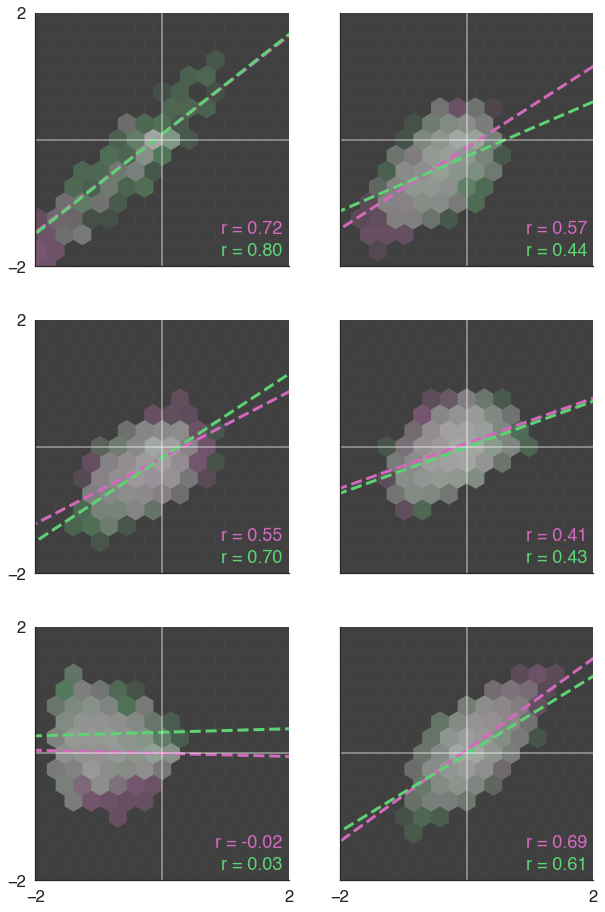

In [630]:
cmap1 = sns.dark_palette((320, 99, 70.), input='husl', as_cmap=True)
cmap2 = sns.dark_palette((132, 99, 90.), input='husl', as_cmap=True)

lim = 2.

vmax_ratio = 20
vmin_ratio = 5.
gamma = .3

for i, subject in enumerate(df.subject_.unique()):
    
    ax= plt.subplot(3, 2, i+1)

    d = df[(df.subject_ == subject) & (df.hemi == 'lh')]
    vmin = len(d) / 25**2 * vmin_ratio
    vmax = len(d) / 25**2 * vmax_ratio

    norm = colors.PowerNorm(vmin=vmin, vmax=vmax, gamma=gamma)

    plt.hexbin(d.zmap1, d.zmap2, gridsize=25, extent=(-3.5, 3.5, -3.5, 3.5), cmap=cmap1, alpha=.5, edgecolors='none',
               bins=None, norm=norm, rasterized=True)

    
    X = np.hstack((np.ones((len(d), 1)), d.zmap1.values[:, np.newaxis]))
    beta, _, _, _ = np.linalg.lstsq(X, d.zmap2)    
    x = np.linspace(-3, 3, endpoint=True) 
    plt.plot(x, beta[0] + x*beta[1], c=cmap1(.8), alpha=1., ls='--', lw=3.)
    
    r, _ = ss.pearsonr(d.zmap1, d.zmap2)
    plt.text(lim-.1, -lim+.45, 'r = {:.2f}'.format(r), c=cmap1(.8), va='bottom', ha='right',)


    d = df[(df.subject_ == subject) & (df.hemi == 'rh')]
    vmin = len(d) / 25**2 * vmin_ratio
    vmax = len(d) / 25**2 * vmax_ratio
    norm = colors.PowerNorm(vmin=vmin, vmax=vmax, gamma=gamma)


    plt.hexbin(d.zmap1, d.zmap2, gridsize=25, cmap=cmap2, extent=(-3.5, 3.5, -3.5, 3.5), alpha=.33, edgecolors='none',
              bins=None, norm=norm, rasterized=True)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.gcf().set_size_inches(10, 10)

    

    
    X = np.hstack((np.ones((len(d), 1)), d.zmap1.values[:, np.newaxis]))
    beta, _, _, _ = np.linalg.lstsq(X, d.zmap2)    
    plt.plot(x, beta[0] + x*beta[1], c=cmap2(.8), alpha=1., ls='--', lw=3.)
    
    r, _ = ss.pearsonr(d.zmap1, d.zmap2)
    plt.text(lim - .1, -lim+.1, 'r = {:.2f}'.format(r), c=cmap2(.8), va='bottom', ha='right',)
    
    ax.set_aspect(1)
    
    if not i in [0, 2, 4]:
        plt.yticks([])
    else:
        plt.yticks([-lim, lim])
#         plt.ylabel('Z-value second half')
        
    if i < 4:
        plt.xticks([])
    else:
        plt.xticks([-lim, lim])
#         plt.xlabel('Z-value first half')
    sns.despine()
    
#     plt.title(f'Subject {i+1}', pad=10., style='italic')
    
    ax.set_facecolor('gray')
#     plt.plot([-2.5, 2.5], [-2.5, 2.5], c='white', alpha=.5)

    plt.plot([0, 0], [-lim, lim], c='white', alpha=.5)
    plt.plot([-lim, lim], [0, 0], c='white', alpha=.5)
    
    sns.despine()
    
plt.gcf().set_size_inches(10, 16)

# plt.suptitle('Z-values first half session plotted versus\nsecond half session', y=1.05)
# plt.tight_layout()

plt.savefig('/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/robustness/across_runs.svg', dpi=300, transparent=False)

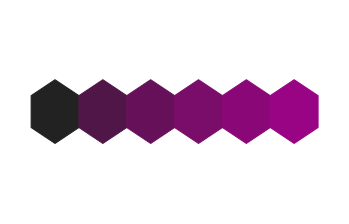

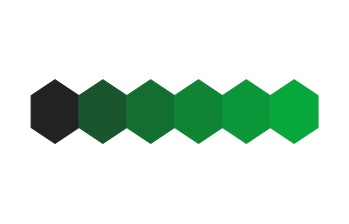

In [593]:
cmap1_ = sns.dark_palette((320, 99, 35.), input='husl', as_cmap=True)
cmap2_ = sns.dark_palette((132, 99, 60.), input='husl', as_cmap=True)

norm = colors.PowerNorm(vmin=0, vmax=1, gamma=.6)

n = 6

plt.hexbin(np.linspace(0, .25, n), [0]*n, C=np.linspace(0, 1., n), cmap=cmap1_, gridsize=5, alpha=1., norm=norm)
plt.gca().set_aspect(1.)
plt.xlim(-.05, .3)
plt.axis('off')
plt.savefig('/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/robustness/legend_left.svg', transparent=True)
# plt.gca().set_facecolor('grey')

plt.figure()
plt.hexbin(np.linspace(0, .25, n), [0]*n, C=np.linspace(0, 1., n), cmap=cmap2_, gridsize=5, alpha=1., norm=norm)
plt.gca().set_aspect(1.)
plt.xlim(-.05, .3)
plt.axis('off')
plt.savefig('/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/robustness/legend_right.svg', transparent=True)

/Users/gdehol/miniconda3/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


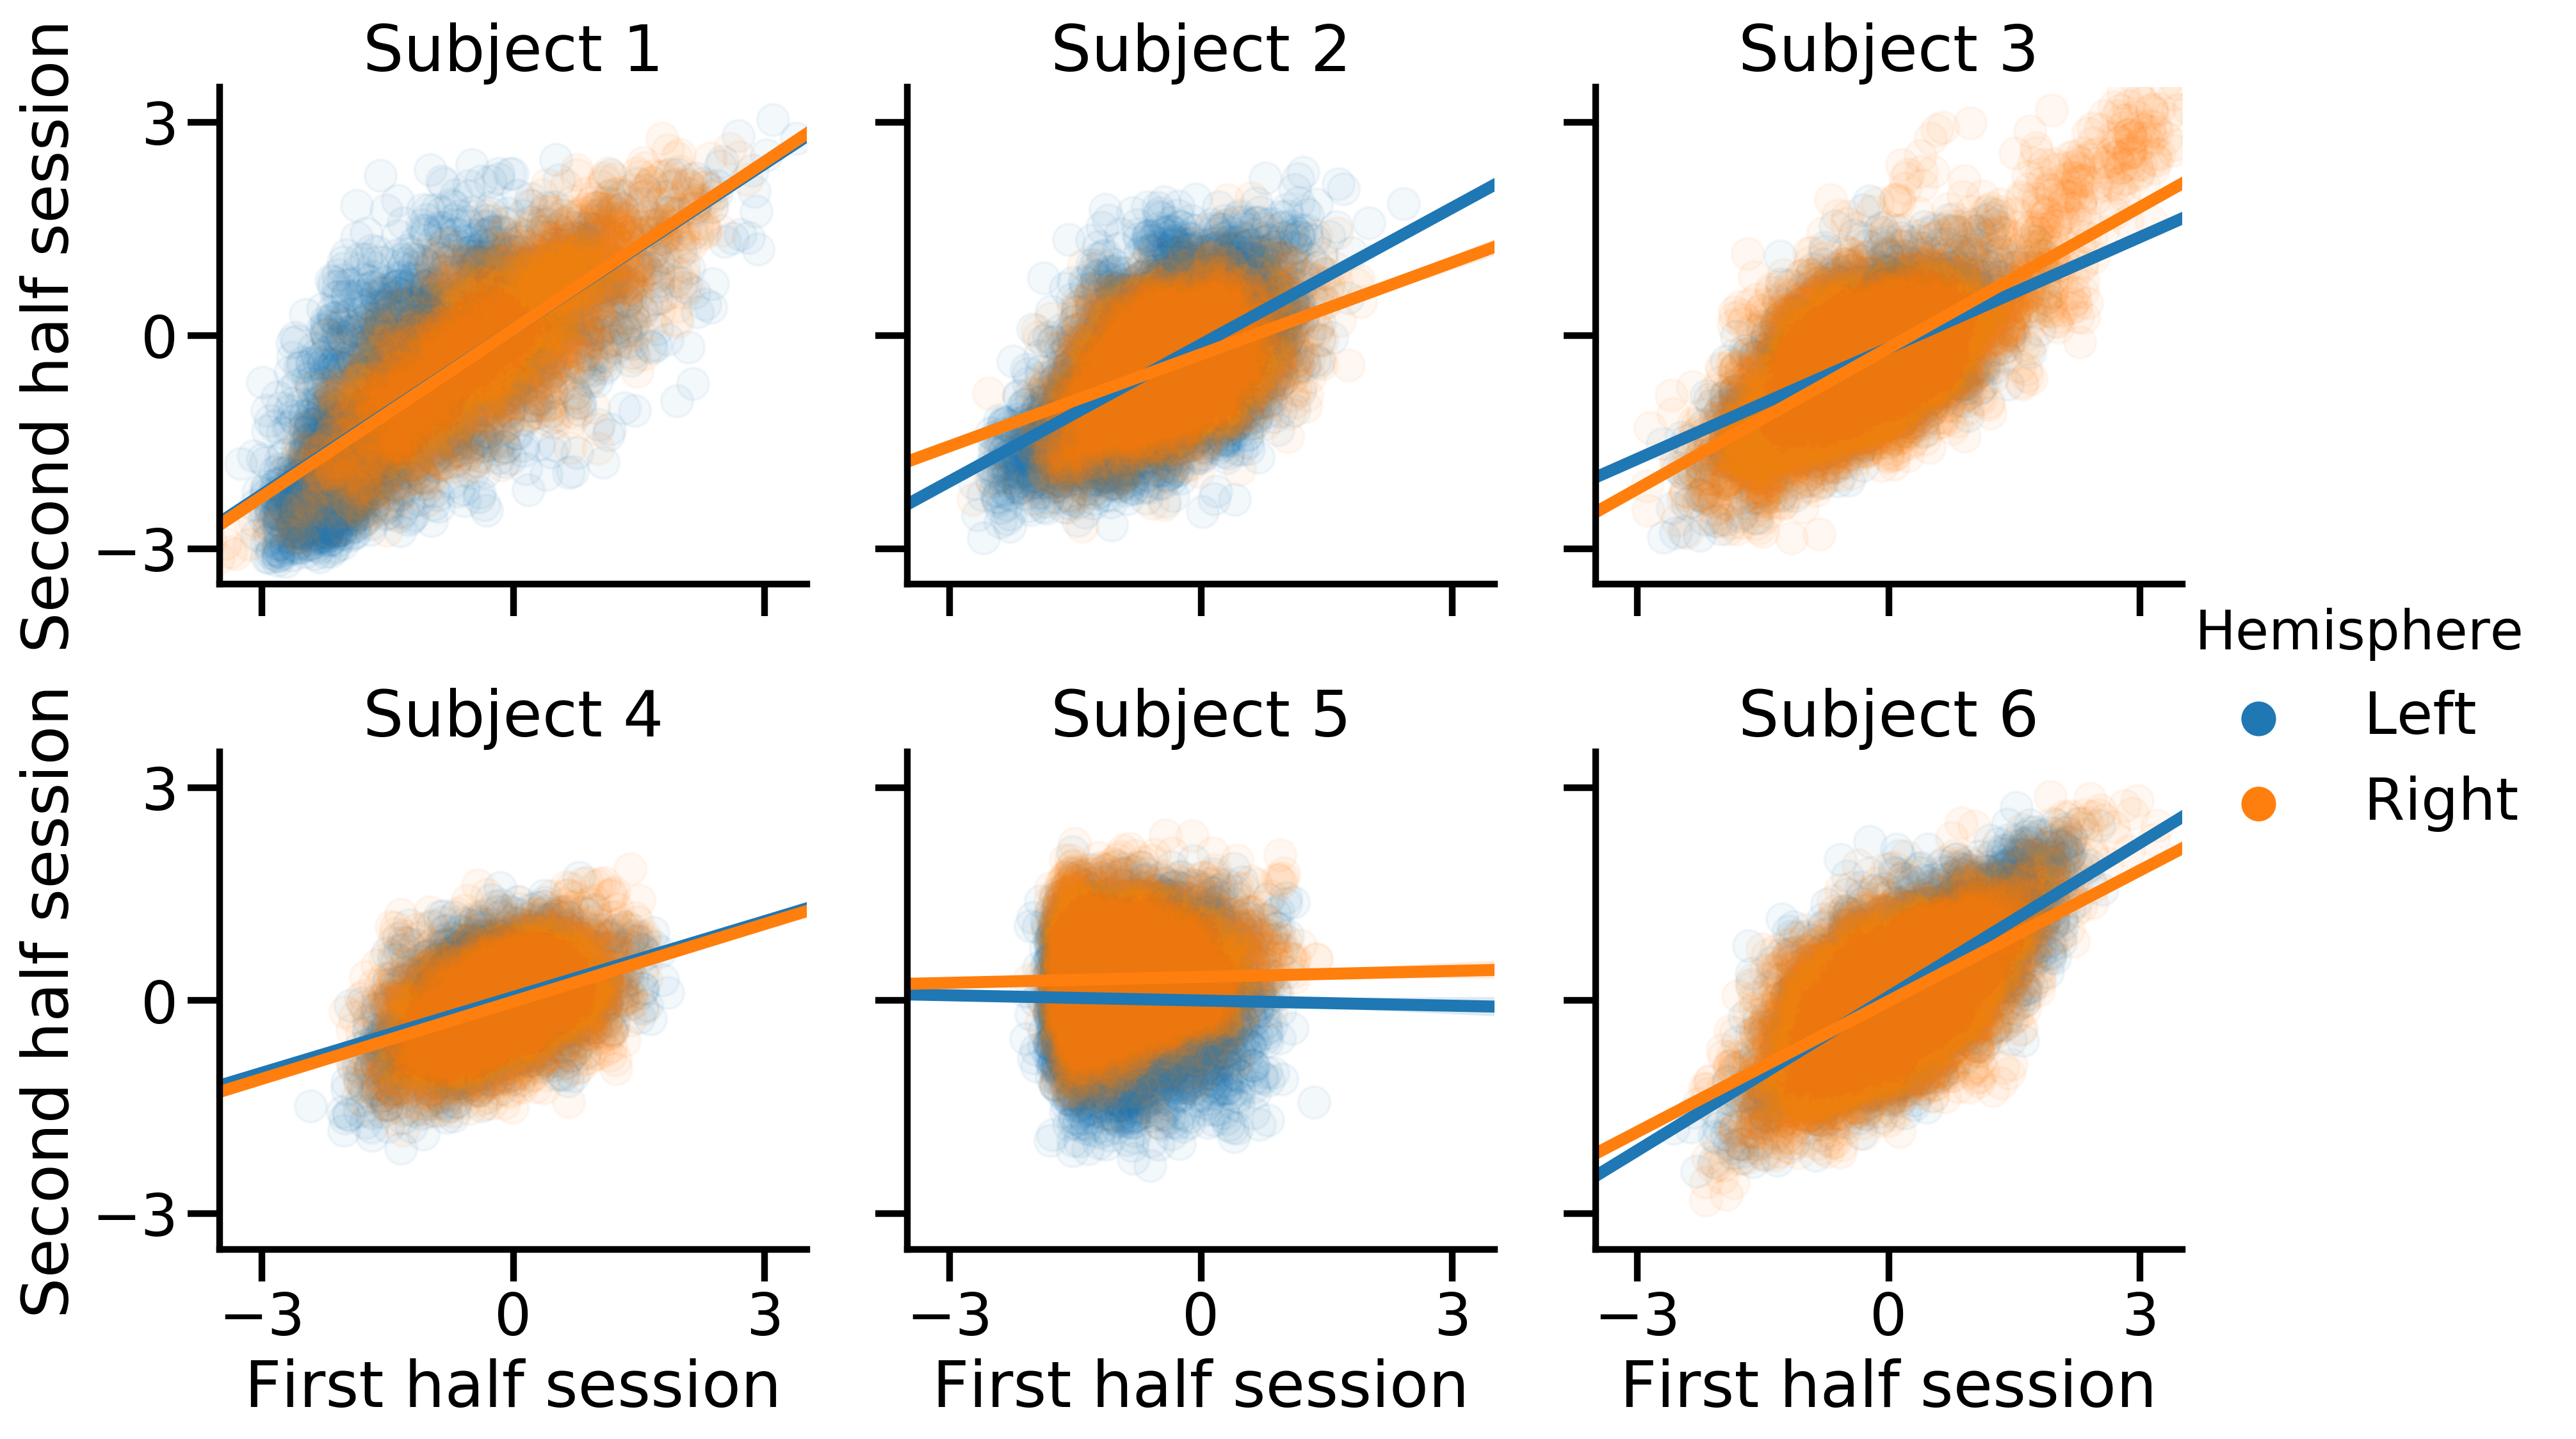

In [380]:
fac = sns.lmplot('First half session', 'Second half session', df, 'Hemisphere', col='subject_', col_wrap=3, sharex=True, sharey=True, aspect=1.,
                truncate=False, scatter_kws={'alpha':.05, 'rasterized':True}, size=4.)
fac.set_titles('Subject {col_name}')
fac.set(xlim=(-3.5, 3.5), ylim=(-3.5, 3.5), xticks=range(-3, 4, 3), yticks=range(-3, 4, 3))

for lh in fac.fig.get_children()[-1].legendHandles:
    lh.set_alpha(1.0)

fac.fig.set_dpi(300)

# fac.ax.legend()
# leg = plt.legend()

# for lh in leg.legendHandles: 
#     lh._legmarker.set_alpha(1.0)

# plt.savefig('/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/figure2/across_subjects.pdf')


In [420]:
import scipy.stats as ss

In [421]:
rs = df.groupby(['subject', 'Hemisphere']).apply(lambda d: ss.pearsonr(d['zmap1'], d['zmap2'])[0])
rs.head()

subject  Hemisphere
bm       Left          0.716420
         Right         0.801522
de       Left          0.572809
         Right         0.441749
eo       Left          0.552403
dtype: float64

In [38]:
rs[~np.in1d(rs.index.get_level_values('subject'), ['ns'])].describe()

count    10.000000
mean      0.592539
std       0.135420
min       0.409936
25%       0.469413
50%       0.590334
75%       0.698326
max       0.801522
dtype: float64

In [39]:
df['same sign'] = np.sign(df['zmap1']) == np.sign(df['zmap2'])

In [41]:
same_sign = df.groupby(['subject', 'Hemisphere']).mean()['same sign']

same_sign[~np.in1d(same_sign.index.get_level_values('subject'), ['ns'])].describe()

count    10.000000
mean      0.699155
std       0.058728
min       0.596662
25%       0.670101
50%       0.696921
75%       0.729948
max       0.787949
Name: same sign, dtype: float64

# Single subject

In [454]:
df2 = []

for subject, session in [('tk', 'odc2'),
                         ('tk', 'odc3'),
                         ('tk', 'cas')]:
    
    left, right = cortex.db.get_surf(f'odc.{subject}', 'fiducial')
    
    for hemi in ['lh', 'rh']:
        mask_str = 'V1{}'.format(hemi[:1])

        surf = glob.glob(f'/data/odc/derivatives/sampled_giis.bak/sub-{subject}/ses-{session}/func/sub-{subject}_ses-{session}_left_over_right_desc-zmap-depth-*_hemi-{hemi}.gii')
        zmap = np.mean([surface.load_surf_data(s) for s in surf], 0)        
        mask = cortex.utils.get_roi_verts(f'odc.{subject}', mask_str)[mask_str]

        if hemi == 'rh':
            mask -= len(left[0])
            
        zmap = zmap[mask]

        d = pd.DataFrame({'zmap':zmap, 'subject':subject, 'hemi':hemi, 'session':session,
                          'vertex':mask})

        df2.append(d)        

In [455]:
df2 = pd.concat(df2)

In [456]:
df2 = df2.pivot_table(index=['subject', 'hemi', 'vertex'], columns='session', values='zmap')

In [457]:
df2 = df2[~(df2 == 0).any(1)]

In [458]:
tmp1, tmp2, tmp3 = df2.copy(), df2.copy(), df2.copy()

tmp = pd.concat((tmp1, 
                 tmp2, 
                 tmp3),
                keys=[('Amsterdam 1', 'Amsterdam 2'), 
                      ('Amsterdam 1', 'Beijing'), 
                      ('Amsterdam 2', 'Beijing')],
               names=['Session 1', 'Session 2'])

In [459]:
tmp['Hemisphere'] = tmp.index.get_level_values('hemi').map({'lh':'Left', 'rh':'Right'})

tmp.loc[('Amsterdam 1'), 'zmap1']  = tmp['odc2']
tmp.loc[('Amsterdam 2'), 'zmap1']  = tmp['odc3']

tmp.loc[(slice(None), 'Amsterdam 2'), 'zmap2']  = tmp['odc3']
tmp.loc[(slice(None), 'Beijing'), 'zmap2']  = tmp['cas']

In [460]:
tmp['sessions'] = list(zip(tmp.index.get_level_values('Session 1'), tmp.index.get_level_values('Session 2')))

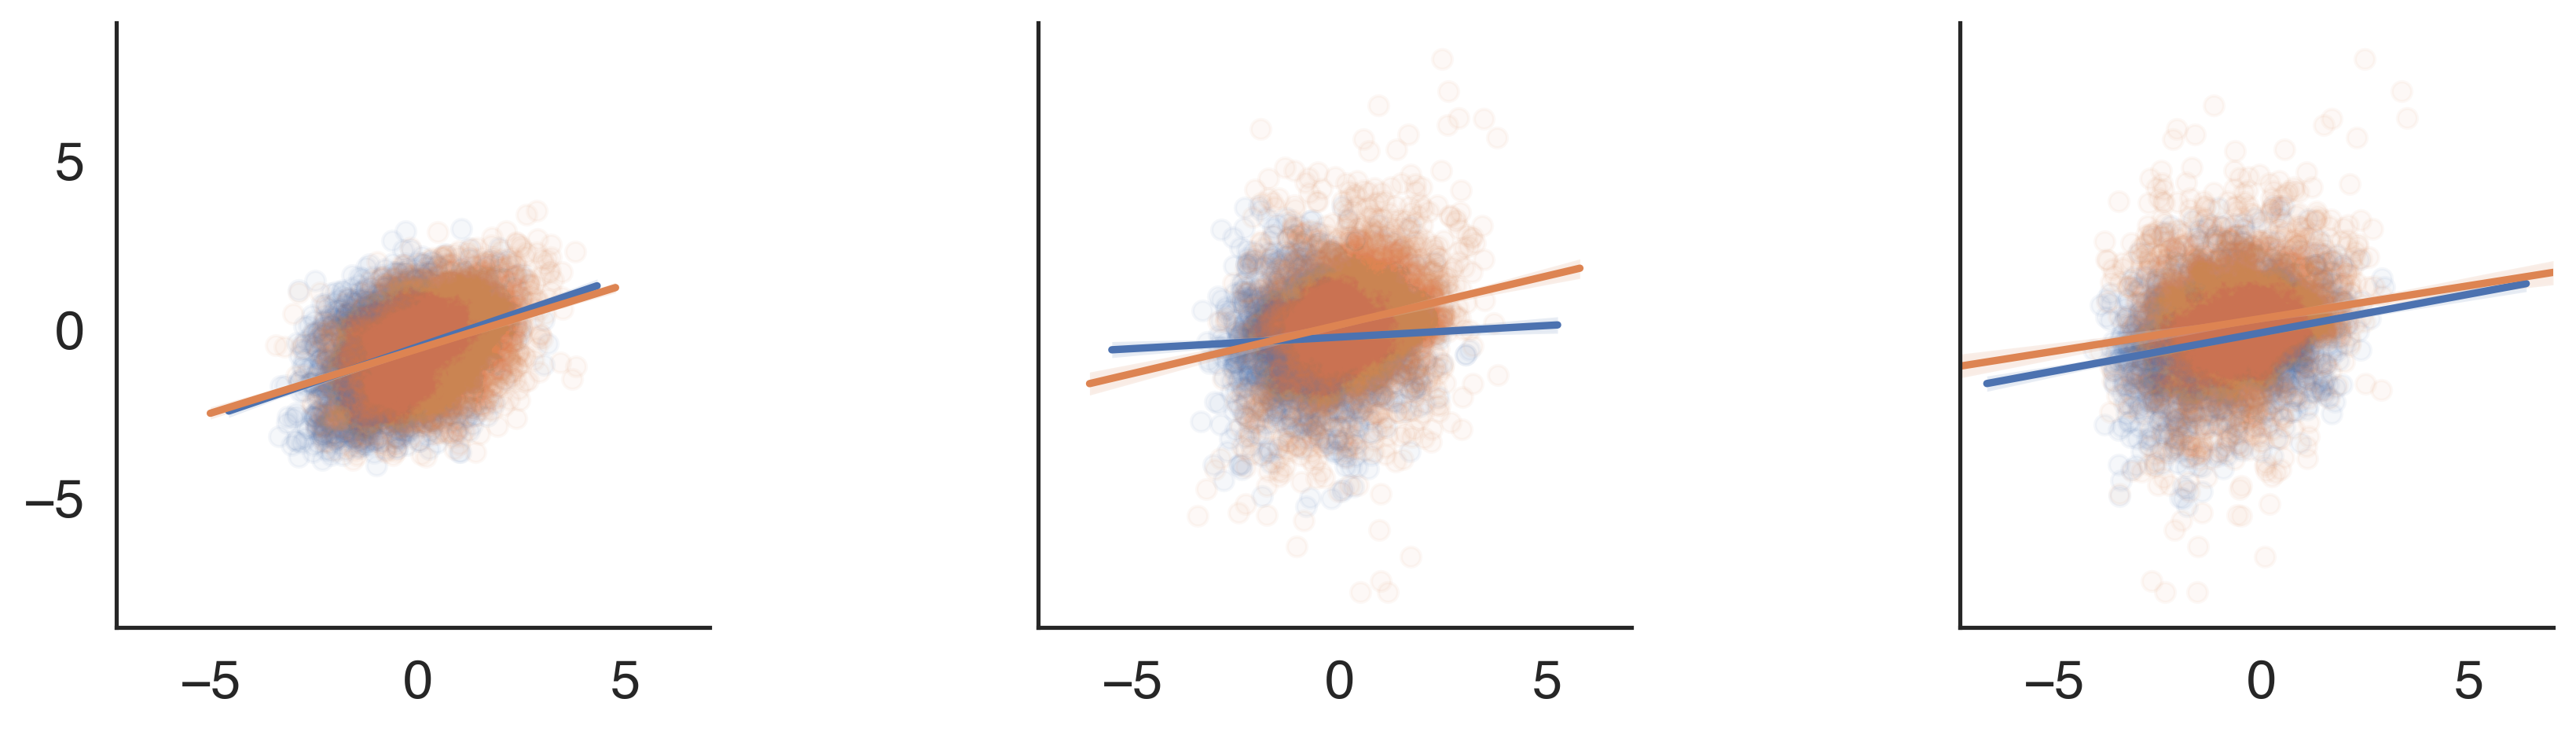

In [462]:
fac = sns.lmplot('zmap1', 'zmap2', 
                 tmp.reset_index(), 'Hemisphere', 
                 col='sessions', col_wrap=3, sharex=True, sharey=True,#, aspect=1.)
                 size=4., legend=False,
               truncate=False, scatter_kws={'alpha':.05, 'rasterized':True})
fac.set_titles('')

fac.set_xlabels('')
fac.set_ylabels('')

# for lh in fac.fig.get_children()[-1].legendHandles:
#     lh.set_alpha(1.0)

fac.axes[0].set_title('')
fac.axes[1].set_title('')
fac.axes[2].set_title('')

fac.fig.set_dpi(300)

# plt.tight_layout()
# plt.savefig("/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/figure3/within_subject.pdf")

In [476]:
tmp = tmp.reset_index()

/Users/gdehol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/gdehol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


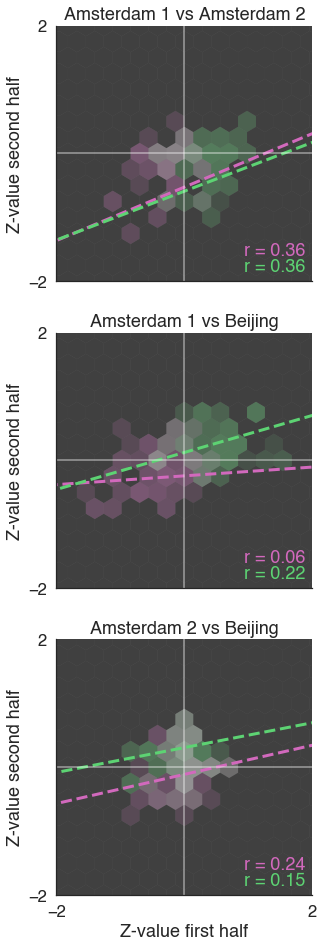

In [627]:
cmap1 = sns.dark_palette((320, 99, 70.), input='husl', as_cmap=True)
cmap2 = sns.dark_palette((132, 99, 90.), input='husl', as_cmap=True)

lim = 2.

vmax_ratio = 12.5
vmin_ratio = 5.
gamma = .3

titles = ['Amsterdam 1 vs Amsterdam 2', 'Amsterdam 1 vs Beijing', 'Amsterdam 2 vs Beijing']

for i, session in enumerate(tmp.sessions.unique()):
    
    ax= plt.subplot(3, 1, i+1)

    d = tmp[(tmp.sessions == session) & (tmp.hemi == 'lh')]
    vmin = len(d) / 25**2 * vmin_ratio
    vmax = len(d) / 25**2 * vmax_ratio

    norm = colors.PowerNorm(vmin=vmin, vmax=vmax, gamma=gamma)

    plt.hexbin(d.zmap1, d.zmap2, gridsize=25, extent=(-3.5, 3.5, -3.5, 3.5), cmap=cmap1, alpha=.5, edgecolors='none',
               bins=None, norm=norm, rasterized=True)

    
    X = np.hstack((np.ones((len(d), 1)), d.zmap1.values[:, np.newaxis]))
    beta, _, _, _ = np.linalg.lstsq(X, d.zmap2)    
    x = np.linspace(-3, 3, endpoint=True) 
    plt.plot(x, beta[0] + x*beta[1], c=cmap1(.8), alpha=1., ls='--', lw=3.)
    
    r, _ = ss.pearsonr(d.zmap1, d.zmap2)
    plt.text(lim-.1, -lim+.35, 'r = {:.2f}'.format(r), c=cmap1(.8), va='bottom', ha='right')


    d = tmp[(tmp.sessions == session) & (tmp.hemi == 'rh')]
    vmin = len(d) / 25**2 * vmin_ratio
    vmax = len(d) / 25**2 * vmax_ratio
    norm = colors.PowerNorm(vmin=vmin, vmax=vmax, gamma=gamma)


    plt.hexbin(d.zmap1, d.zmap2, gridsize=25, cmap=cmap2, extent=(-3.5, 3.5, -3.5, 3.5), alpha=.33, edgecolors='none',
              bins=None, norm=norm, rasterized=True)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.gcf().set_size_inches(10, 10)

    

    
    X = np.hstack((np.ones((len(d), 1)), d.zmap1.values[:, np.newaxis]))
    beta, _, _, _ = np.linalg.lstsq(X, d.zmap2)    
    plt.plot(x, beta[0] + x*beta[1], c=cmap2(.8), alpha=1., ls='--', lw=3.)
    
    r, _ = ss.pearsonr(d.zmap1, d.zmap2)
    plt.text(lim - .1, -lim+.1, 'r = {:.2f}'.format(r), c=cmap2(.8), va='bottom', ha='right')
    
    ax.set_aspect(1)
    

    plt.yticks([-lim, lim])
    plt.ylabel('Z-value second half')
        
    if i < 2:
        plt.xticks([])
    else:
        plt.xticks([-lim, lim])
        plt.xlabel('Z-value first half')
    sns.despine()
    
    plt.title(titles[i])
    
    ax.set_facecolor('gray')
#     plt.plot([-2.5, 2.5], [-2.5, 2.5], c='white', alpha=.5)

    plt.plot([0, 0], [-lim, lim], c='white', alpha=.5)
    plt.plot([-lim, lim], [0, 0], c='white', alpha=.5)
    
plt.gcf().set_size_inches(10, 16)
# plt.tight_layout()

plt.savefig('/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/robustness/across_sessions.svg', dpi=300, transparent=False)

In [ ]:
tmp.groupby(['Session 1', 'Session 2', 'Hemisphere']).apply(lambda d: ss.pearsonr(d['zmap1'], d['zmap2'])[0]).to_frame('r').T

In [ ]:
tmp['same sign'] = np.sign(tmp['zmap1']) == np.sign(tmp['zmap2'])

In [ ]:
tmp.groupby(['Session 1', 'Session 2', 'Hemisphere']).mean()[['same sign']]